## 数据集获取

可在[AIStudio下载数据集](https://aistudio.baidu.com/aistudio/datasetdetail/68178)，关于数据集的详细描述可以参见我之前的一篇博客[主成分分析原理及应用](https://blog.csdn.net/qq_39567427/article/details/107045265)

## 导入必要的包

In [1]:
import paddle
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import paddle.nn.functional as F
import warnings
from paddle.io import Dataset
warnings.filterwarnings("ignore")

paddle.__version__

'2.0.0-rc1'

## 数据处理

In [2]:
%matplotlib inline

你可以通过以下代码读取数据文件并可视化
```python
import pandas as pd
df_data = pd.read_csv('iris.csv')
df_data
```
很明显可以发现鸢尾花的类别使用字符串表示的，因此我们可以利用字典将字符串映射为整数

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Unnamed: 0</th>
      <th>Sepal.Length</th>
      <th>Sepal.Width</th>
      <th>Petal.Length</th>
      <th>Petal.Width</th>
      <th>Species</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>5.1</td>
      <td>3.5</td>
      <td>1.4</td>
      <td>0.2</td>
      <td>setosa</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>4.9</td>
      <td>3.0</td>
      <td>1.4</td>
      <td>0.2</td>
      <td>setosa</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>4.7</td>
      <td>3.2</td>
      <td>1.3</td>
      <td>0.2</td>
      <td>setosa</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>4.6</td>
      <td>3.1</td>
      <td>1.5</td>
      <td>0.2</td>
      <td>setosa</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>5.0</td>
      <td>3.6</td>
      <td>1.4</td>
      <td>0.2</td>
      <td>setosa</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <th>145</th>
      <td>146</td>
      <td>6.7</td>
      <td>3.0</td>
      <td>5.2</td>
      <td>2.3</td>
      <td>virginica</td>
    </tr>
    <tr>
      <th>146</th>
      <td>147</td>
      <td>6.3</td>
      <td>2.5</td>
      <td>5.0</td>
      <td>1.9</td>
      <td>virginica</td>
    </tr>
    <tr>
      <th>147</th>
      <td>148</td>
      <td>6.5</td>
      <td>3.0</td>
      <td>5.2</td>
      <td>2.0</td>
      <td>virginica</td>
    </tr>
    <tr>
      <th>148</th>
      <td>149</td>
      <td>6.2</td>
      <td>3.4</td>
      <td>5.4</td>
      <td>2.3</td>
      <td>virginica</td>
    </tr>
    <tr>
      <th>149</th>
      <td>150</td>
      <td>5.9</td>
      <td>3.0</td>
      <td>5.1</td>
      <td>1.8</td>
      <td>virginica</td>
    </tr>
  </tbody>
</table>
</div>

定义数据处理函数，主要是读取数据集并将类别映射为整数

In [3]:
def datafram_dealt(data):
    df_data = pd.read_csv(data)
    df = df_data.drop(['Unnamed: 0'], axis=1)
    class_name = list(df['Species'].drop_duplicates())
    df['Species'] = df['Species'].map({class_name[0]:0, class_name[1]:1, class_name[2]:2}).astype(int)
    df = df.sample(frac=1)
    dick_map = {class_name[0]:0, class_name[1]:1, class_name[2]:2}
    
    return df, dick_map

In [4]:
df, dick_map = datafram_dealt('iris.csv')

In [5]:
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
114,5.8,2.8,5.1,2.4,2
97,6.2,2.9,4.3,1.3,1
72,6.3,2.5,4.9,1.5,1
46,5.1,3.8,1.6,0.2,0
15,5.7,4.4,1.5,0.4,0
...,...,...,...,...,...
24,4.8,3.4,1.9,0.2,0
105,7.6,3.0,6.6,2.1,2
148,6.2,3.4,5.4,2.3,2
109,7.2,3.6,6.1,2.5,2


In [6]:
dick_map

{'setosa': 0, 'versicolor': 1, 'virginica': 2}

我们仍然可以通过箱图查看数据的分布情况，可以发现数据的分布差距不是特别大

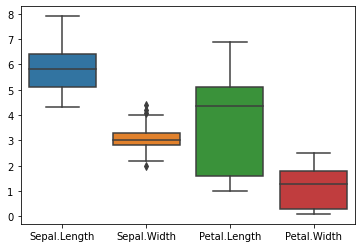

In [7]:
sns.boxplot(data=df.iloc[:, 0:4])
plt.show()

这里我们采用最简单的数据归一化方式，直接用每一列数据除以本列中数据的最大值

In [8]:
def normalize(data):
    features = np.zeros(np.array(data.shape))
    for i in range(data.shape[1]):
        features[:,i] = np.array(data)[:,i] / np.max(np.array(data)[:,i])
    return features

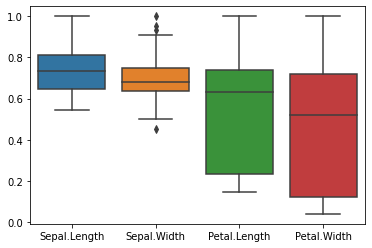

In [9]:
features_np = normalize(df.iloc[:, 0:4])
labels_np = df.iloc[:, -1]

df_features_np = pd.DataFrame(features_np, columns=['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'])
sns.boxplot(data=df_features_np)
plt.show()

## 数据集制作

将总数据的0.8倍作为训练集，剩下部分作为验证集

In [10]:
dataset = np.c_[features_np, labels_np].astype('float32')
ratio = 0.8
train_dataset = dataset[:int(dataset.shape[0] * 0.8), :]
val_dataset = dataset[int(dataset.shape[0] * 0.8):, :]

定义`MyDataset`数据类

In [11]:
class MyDataset(Dataset):
    def __init__(self, mode='train'):
        super(MyDataset, self).__init__()
        if mode == 'train':
            self.data = [[train_dataset[i][:4], train_dataset[i][-1].astype('int64')] for i in range(train_dataset.shape[0])]
        else:
            self.data = [[val_dataset[i][:4], val_dataset[i][-1].astype('int64')] for i in range(val_dataset.shape[0])]

    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)


In [12]:
train_loader = paddle.io.DataLoader(MyDataset(mode='train'), batch_size=int(dataset.shape[0] * 0.8), shuffle=True)

## 建模训练

这里采用Paddle的高层API及其低阶API两种方式进行训练

### 使用Paddle高层API

In [13]:
classification = paddle.nn.Sequential(
    paddle.nn.Linear(4, 3)
)

model = paddle.Model(classification)
model.summary((4))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1            [[4]]                 [3]                15       
Total params: 15
Trainable params: 15
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------------------------------



{'total_params': 15, 'trainable_params': 15}

In [14]:
model.prepare(optimizer=paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())
callback = paddle.callbacks.VisualDL(log_dir='log')

In [15]:
model.fit(train_loader,
          epochs=500,
          batch_size=64,
          verbose=1,
          callbacks=callback)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/500
step 1/1 [==============================] - loss: 1.2485 - acc: 0.3250 - 234ms/step
Epoch 2/500
step 1/1 [==============================] - loss: 1.2003 - acc: 0.3250 - 9ms/step
Epoch 3/500
step 1/1 [==============================] - loss: 1.1612 - acc: 0.3250 - 9ms/step
Epoch 4/500
step 1/1 [==============================] - loss: 1.1290 - acc: 0.3250 - 11ms/step
Epoch 5/500
step 1/1 [==============================] - loss: 1.1022 - acc: 0.3250 - 11ms/step
Epoch 6/500
step 1/1 [==============================] - loss: 1.0795 - acc: 0.3083 - 16ms/step
Epoch 7/500
step 1/1 [==============================] - loss: 1.0603 - acc: 0.2833 - 13ms/step
Epoch 8/500
step 1/1 [==============================] - loss: 1.0439 - acc: 0.2667 - 9ms/step
Epoch 9/500
step 1/1 [==============================] - loss: 1.0298 - acc: 0.2583 - 9ms/step
Epoch 10/500
step 1/1 [================

Epoch 86/500
step 1/1 [==============================] - loss: 0.7102 - acc: 0.8250 - 8ms/step
Epoch 87/500
step 1/1 [==============================] - loss: 0.7080 - acc: 0.8250 - 9ms/step
Epoch 88/500
step 1/1 [==============================] - loss: 0.7058 - acc: 0.8250 - 11ms/step
Epoch 89/500
step 1/1 [==============================] - loss: 0.7037 - acc: 0.8250 - 9ms/step
Epoch 90/500
step 1/1 [==============================] - loss: 0.7015 - acc: 0.8250 - 7ms/step
Epoch 91/500
step 1/1 [==============================] - loss: 0.6994 - acc: 0.8250 - 9ms/step
Epoch 92/500
step 1/1 [==============================] - loss: 0.6973 - acc: 0.8250 - 11ms/step
Epoch 93/500
step 1/1 [==============================] - loss: 0.6952 - acc: 0.8250 - 8ms/step
Epoch 94/500
step 1/1 [==============================] - loss: 0.6932 - acc: 0.8333 - 10ms/step
Epoch 95/500
step 1/1 [==============================] - loss: 0.6912 - acc: 0.8333 - 10ms/step
Epoch 96/500
step 1/1 [=======================

Epoch 171/500
step 1/1 [==============================] - loss: 0.5810 - acc: 0.8917 - 13ms/step
Epoch 172/500
step 1/1 [==============================] - loss: 0.5799 - acc: 0.8917 - 9ms/step
Epoch 173/500
step 1/1 [==============================] - loss: 0.5789 - acc: 0.8917 - 23ms/step
Epoch 174/500
step 1/1 [==============================] - loss: 0.5778 - acc: 0.8917 - 14ms/step
Epoch 175/500
step 1/1 [==============================] - loss: 0.5768 - acc: 0.8917 - 12ms/step
Epoch 176/500
step 1/1 [==============================] - loss: 0.5758 - acc: 0.8917 - 12ms/step
Epoch 177/500
step 1/1 [==============================] - loss: 0.5748 - acc: 0.8917 - 10ms/step
Epoch 178/500
step 1/1 [==============================] - loss: 0.5737 - acc: 0.8917 - 16ms/step
Epoch 179/500
step 1/1 [==============================] - loss: 0.5727 - acc: 0.8917 - 15ms/step
Epoch 180/500
step 1/1 [==============================] - loss: 0.5717 - acc: 0.8917 - 13ms/step
Epoch 181/500
step 1/1 [=======

Epoch 256/500
step 1/1 [==============================] - loss: 0.5108 - acc: 0.9250 - 10ms/step
Epoch 257/500
step 1/1 [==============================] - loss: 0.5101 - acc: 0.9250 - 7ms/step
Epoch 258/500
step 1/1 [==============================] - loss: 0.5095 - acc: 0.9167 - 10ms/step
Epoch 259/500
step 1/1 [==============================] - loss: 0.5088 - acc: 0.9167 - 8ms/step
Epoch 260/500
step 1/1 [==============================] - loss: 0.5082 - acc: 0.9167 - 7ms/step
Epoch 261/500
step 1/1 [==============================] - loss: 0.5075 - acc: 0.9167 - 11ms/step
Epoch 262/500
step 1/1 [==============================] - loss: 0.5069 - acc: 0.9250 - 11ms/step
Epoch 263/500
step 1/1 [==============================] - loss: 0.5062 - acc: 0.9250 - 6ms/step
Epoch 264/500
step 1/1 [==============================] - loss: 0.5056 - acc: 0.9250 - 9ms/step
Epoch 265/500
step 1/1 [==============================] - loss: 0.5050 - acc: 0.9250 - 9ms/step
Epoch 266/500
step 1/1 [============

Epoch 341/500
step 1/1 [==============================] - loss: 0.4640 - acc: 0.9417 - 11ms/step
Epoch 342/500
step 1/1 [==============================] - loss: 0.4635 - acc: 0.9417 - 8ms/step
Epoch 343/500
step 1/1 [==============================] - loss: 0.4630 - acc: 0.9417 - 13ms/step
Epoch 344/500
step 1/1 [==============================] - loss: 0.4626 - acc: 0.9417 - 8ms/step
Epoch 345/500
step 1/1 [==============================] - loss: 0.4621 - acc: 0.9500 - 11ms/step
Epoch 346/500
step 1/1 [==============================] - loss: 0.4616 - acc: 0.9500 - 12ms/step
Epoch 347/500
step 1/1 [==============================] - loss: 0.4612 - acc: 0.9500 - 12ms/step
Epoch 348/500
step 1/1 [==============================] - loss: 0.4607 - acc: 0.9500 - 8ms/step
Epoch 349/500
step 1/1 [==============================] - loss: 0.4603 - acc: 0.9500 - 13ms/step
Epoch 350/500
step 1/1 [==============================] - loss: 0.4598 - acc: 0.9500 - 12ms/step
Epoch 351/500
step 1/1 [=========

Epoch 426/500
step 1/1 [==============================] - loss: 0.4291 - acc: 0.9583 - 8ms/step
Epoch 427/500
step 1/1 [==============================] - loss: 0.4288 - acc: 0.9583 - 11ms/step
Epoch 428/500
step 1/1 [==============================] - loss: 0.4284 - acc: 0.9583 - 10ms/step
Epoch 429/500
step 1/1 [==============================] - loss: 0.4281 - acc: 0.9583 - 10ms/step
Epoch 430/500
step 1/1 [==============================] - loss: 0.4277 - acc: 0.9583 - 8ms/step
Epoch 431/500
step 1/1 [==============================] - loss: 0.4274 - acc: 0.9583 - 10ms/step
Epoch 432/500
step 1/1 [==============================] - loss: 0.4270 - acc: 0.9583 - 14ms/step
Epoch 433/500
step 1/1 [==============================] - loss: 0.4266 - acc: 0.9583 - 19ms/step
Epoch 434/500
step 1/1 [==============================] - loss: 0.4263 - acc: 0.9583 - 30ms/step
Epoch 435/500
step 1/1 [==============================] - loss: 0.4259 - acc: 0.9583 - 86ms/step
Epoch 436/500
step 1/1 [========

### 模型验证

In [16]:
model.evaluate(MyDataset(mode='test'), batch_size=64, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 0.3892 - acc: 0.9333 - 15ms/step
Eval samples: 30


{'loss': [0.38916063], 'acc': 0.9333333333333333}

In [17]:
pred_result = model.predict(MyDataset(mode='test'))
result = [np.argmax(pred_result[0][i]) for i in range(len(pred_result[0]))]
label = [label for _, label in MyDataset(mode='test')]

Predict begin...
step 30/30 [==============================] - 3ms/step          
Predict samples: 30


In [18]:
result_name = [list(dick_map.keys())[result[i]] for i in range(len(result))]
label_name = [list(dick_map.keys())[label[i]] for i in range(len(label))]

result_name.insert(0, 'Predict')
label_name.insert(0, 'Label')

In [19]:
pd.DataFrame([result_name, label_name])

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,Predict,virginica,setosa,virginica,versicolor,virginica,versicolor,virginica,setosa,virginica,...,versicolor,versicolor,setosa,versicolor,virginica,versicolor,setosa,virginica,setosa,setosa
1,Label,virginica,setosa,virginica,virginica,virginica,versicolor,virginica,setosa,versicolor,...,versicolor,versicolor,setosa,versicolor,virginica,versicolor,setosa,virginica,setosa,setosa




### 使用Paddle低阶API

In [20]:
class Classificationv2(paddle.nn.Layer):
    def __init__(self):
        super(Classificationv2, self).__init__()
        self.fc = paddle.nn.Linear(4, 3,)

    def forward(self, inputs):
        pred = self.fc(inputs)
        return pred

In [21]:
network = Classificationv2()
model = paddle.Model(network)
model.summary((4))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-2            [[4]]                 [3]                15       
Total params: 15
Trainable params: 15
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------------------------------



{'total_params': 15, 'trainable_params': 15}

In [22]:
print('start training ... ')

EPOCH_NUM = 500
BATCH_SIZE = 64
train_num = 0
train_loss_list = []
train_acc_list = []
optimizer = paddle.optimizer.SGD(learning_rate=0.2, parameters=network.parameters())

network.train()

for epoch_id in range(EPOCH_NUM):
    loss_list_each_epoch = []
    acc_list_each_epoch = []
    np.random.shuffle(train_dataset)
    mini_batches = [train_dataset[k: k+BATCH_SIZE] for k in range(0, len(train_dataset), BATCH_SIZE)]
    for batch_id, data in enumerate(mini_batches):
        features_np = np.array(data[:, :4], np.float32)
        labels_np = np.array(data[:, -1:], np.int64)
        features = paddle.to_tensor(features_np)
        labels = paddle.to_tensor(labels_np)
        y_pred = network(features)
        loss = F.cross_entropy(y_pred, label=labels)
        train_loss = loss.numpy()[0]
        train_acc = sum(labels.numpy().flatten() == paddle.argmax(y_pred, axis=1, keepdim=False, dtype='int64', name=None).numpy()) / len(labels.numpy().flatten())
        loss_list_each_epoch.append(train_loss)
        acc_list_each_epoch.append(train_acc)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
    train_loss_list.append(np.average(loss_list_each_epoch))
    train_acc_list.append(np.average(acc_list_each_epoch))
    if epoch_id%50 == 0:
        print("INFO:%3d,Loss:%0.5f,Acc:%0.5f"%(epoch_id +50, np.average(loss_list_each_epoch), np.average(acc_list_each_epoch)))

start training ... 
INFO: 50,Loss:1.09513,Acc:0.32924
INFO:100,Loss:0.67959,Acc:0.76451
INFO:150,Loss:0.55066,Acc:0.90960
INFO:200,Loss:0.48390,Acc:0.95871
INFO:250,Loss:0.43779,Acc:0.96763
INFO:300,Loss:0.40674,Acc:0.96429
INFO:350,Loss:0.37579,Acc:0.96652
INFO:400,Loss:0.35439,Acc:0.96763
INFO:450,Loss:0.33448,Acc:0.96763
INFO:500,Loss:0.32024,Acc:0.96652


## VisualDL可视化
在高阶API训练时，采用了`callbacks`来记录中间结果，因此可以使用`visualdl --logdir ./log`进行可视化

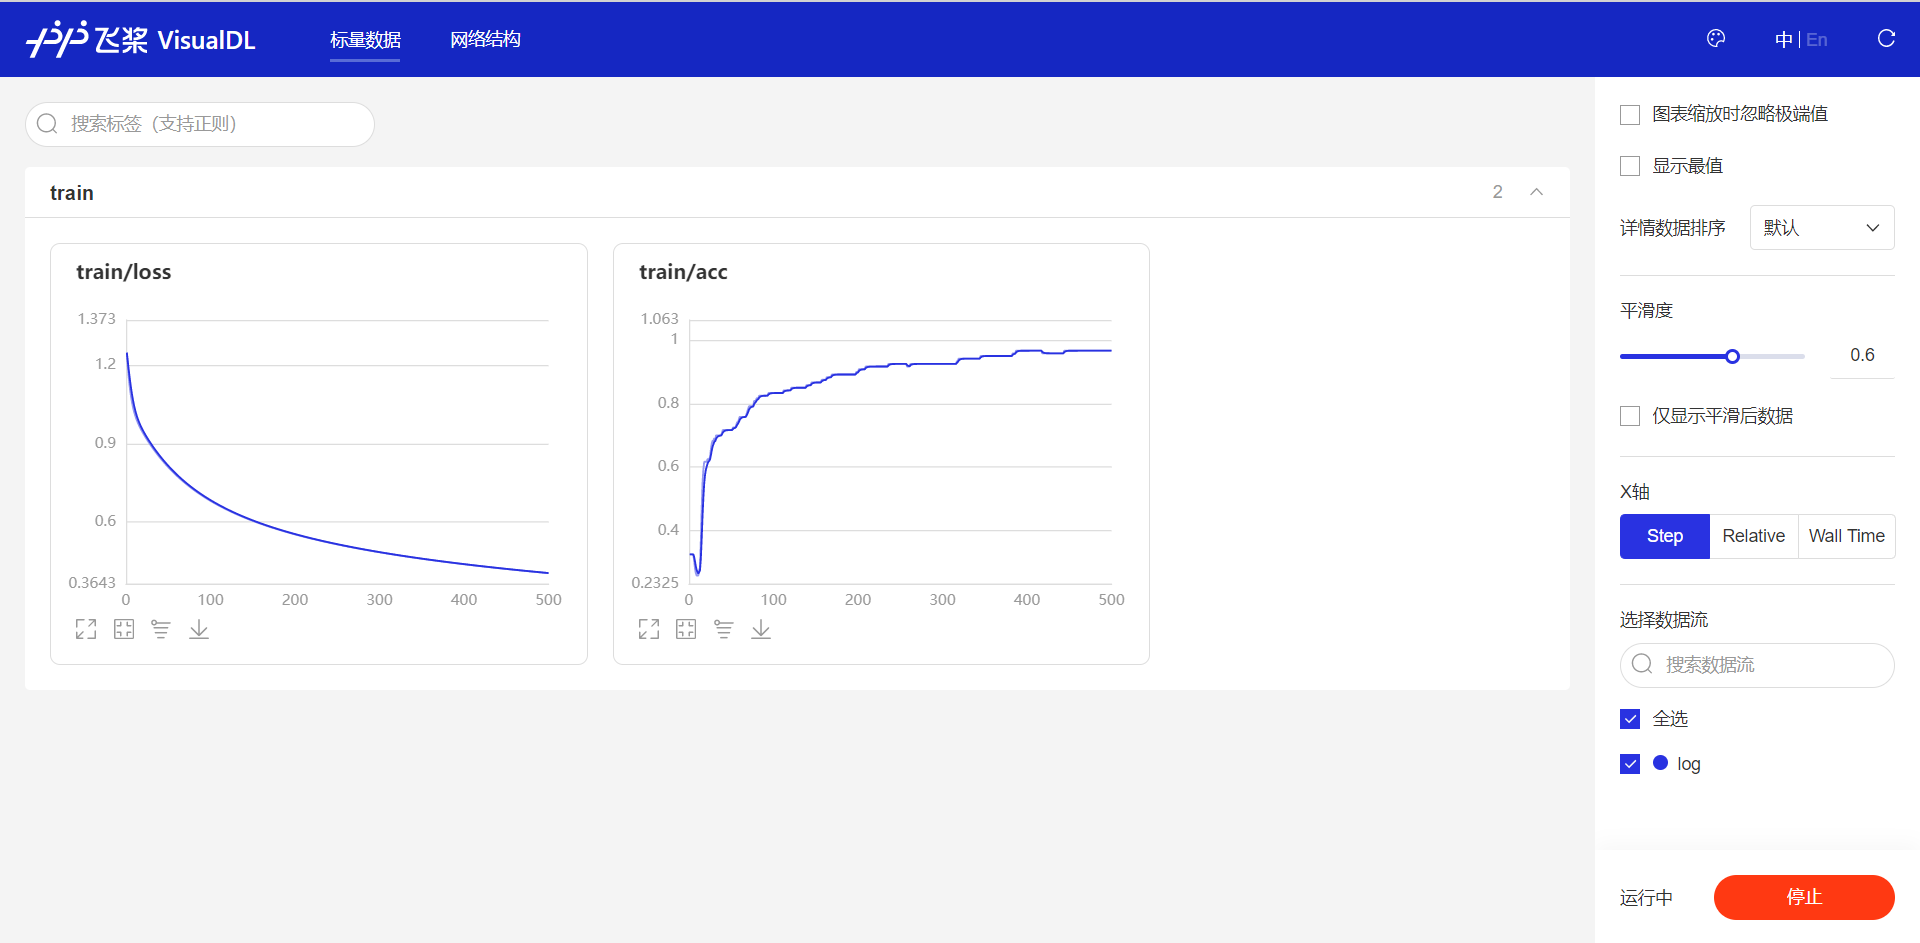